# Athletes Prediction

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

In [9]:
# Check for GPU availability and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [10]:
np.random.seed(42)

In [11]:
og_df = pd.read_csv('data/raw_data.csv')
data = pd.read_csv('data/complete_dataset.csv')
df_pca = pd.read_csv('data/gnn_cluster.csv')

# Cluster Classification
Classify new users at a certain Date/Time to a certain cluster (also considering wearable data and missing values)

### Gradient Boosting

Perform supervised learning with **gradient boosting** on clusters generated from NLP approach.

In [12]:
df_full = og_df.merge(data[['User ID', 'Date/Time', 'Cluster']], on=['User ID', 'Date/Time'], how='left')

# drop as few NaNs as possible or impute
X = df_full.drop(columns=['Cluster', 'User ID', 'Date/Time', 'Gender', 'Phone', 'Actions', 'With', 'Reflections']).fillna(0)
y = df_full['Cluster']

# fill wearable NaNs with zero
X = X.fillna(0)
mask = ~y.isna()
X = X[mask]
y = y[mask]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

y_pred = gb_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8908170643528561
Report:
               precision    recall  f1-score   support

         0.0       0.85      0.86      0.85       428
         1.0       0.95      0.94      0.94       496
         2.0       0.87      0.88      0.87       459

    accuracy                           0.89      1383
   macro avg       0.89      0.89      0.89      1383
weighted avg       0.89      0.89      0.89      1383



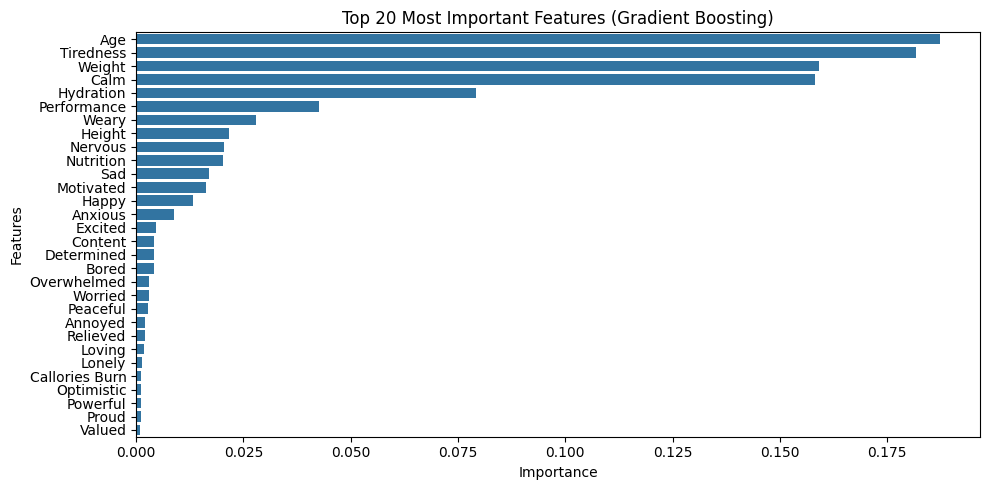

In [13]:
feature_importance = pd.Series(gb_model.feature_importances_, index=X.columns)
top_features = feature_importance.sort_values(ascending=False).head(30)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top 20 Most Important Features (Gradient Boosting)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

### Random Forest

Perform supervised learning with **random forest** on clusters generated from GNN approach.

In [16]:
# Ensure column names match
df_pca = df_pca.rename(columns={'userid': 'User ID', 'timestamp': 'Date/Time'})

# Merge cluster labels from df_pca
df_gnn_pred = og_df.merge(df_pca[['User ID', 'Date/Time', 'Cluster']], on=['User ID', 'Date/Time'], how='left')

X = df_gnn_pred.drop(columns=['Cluster', 'User ID', 'Date/Time', 'Gender', 'Phone', 'Actions', 'With', 'Reflections'])
y = df_gnn_pred['Cluster']

# fill wearable NaNs with zero
X = X.fillna(0)
mask = ~y.isna()
X = X[mask]
y = y[mask]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5869565217391305
Report:
               precision    recall  f1-score   support

         0.0       1.00      0.67      0.80        18
         1.0       0.42      0.50      0.46        16
         2.0       0.47      0.58      0.52        12

    accuracy                           0.59        46
   macro avg       0.63      0.58      0.59        46
weighted avg       0.66      0.59      0.61        46



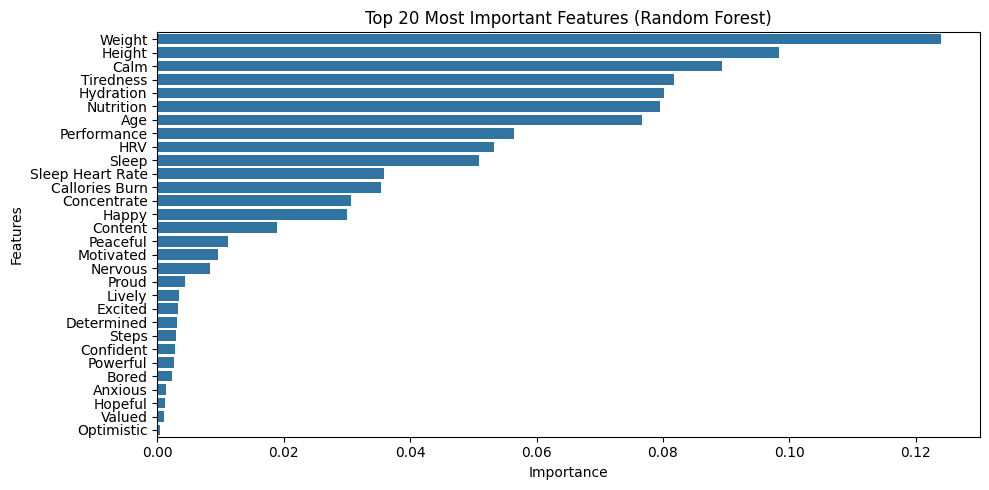

In [15]:
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
top_features = feature_importance.sort_values(ascending=False).head(30)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top 20 Most Important Features (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()